# Building Machine Learning Models for Predicting Survival in Lower Grade Glioma

### Jack Welland

##### Transcriptomic datasets for LGG from the TCGA will be used for prediction. TCGA datasets have already been utilised for iMAT-based transcriptomic integratative metabolic modelling to predict reaction fluxes for relavant GSL reactions using a GSL metabolism specific model. This was done with pyGSLModel built on top of cobrapy. The simulated reaction fluxes will be used effectively as engineered features, with the idea that they may improve model performance.

# Perfoming Cross Validation Across Different Models and Datasets

Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import copy

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier


from imblearn.over_sampling import SMOTE

Defining Focal Loss

In [2]:
class FocalLoss(nn.Module):
    """
    Binary focal loss for logits.
    """
    def __init__(self, alpha=0.25, gamma=5, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        targets = targets.view(-1, 1).type_as(logits)  # Make sure targets are (batch, 1) and same type as logits
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, reduction='none'
        )

        # Compute pt
        pt = torch.exp(-bce_loss)

        # Apply focal term
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


Defining the model architecture

In [3]:
class Deep(nn.Module):
    """
    Deep feedforward model for binary classification (outputs logits).
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=4, dropout_rate=0.25):
        super().__init__()
        layers = []
        in_dim = input_dim

        for _ in range(num_layers):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden_dim

        # Final output layer — raw logits (no sigmoid here!)
        layers.append(nn.Linear(hidden_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # raw logits

Defining the training function

In [4]:
# === Deep model training function ===
def model_train(model, X_train, y_train, X_val, y_val):
    # Ensure PyTorch tensors
    if isinstance(X_train, np.ndarray):
        X_train = torch.tensor(X_train, dtype=torch.float32)
    if isinstance(y_train, np.ndarray):
        y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    if isinstance(X_val, np.ndarray):
        X_val = torch.tensor(X_val, dtype=torch.float32)
    if isinstance(y_val, np.ndarray):
        y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    loss_fn = FocalLoss(alpha=0.25, gamma =5)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    n_epochs = 300
    batch_size = 128

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=len(y_val), shuffle=False)

    best_acc = -np.inf
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                logits = model(X_val_batch)
                probs  = torch.sigmoid(logits)
                preds  = (probs >= 0.5).float()
                acc    = (preds == y_val_batch).float().mean()
                if acc > best_acc:
                    best_acc = acc
                    best_weights = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_weights)
    model.eval()

    with torch.no_grad():
        logits = model(X_val)
        probs  = torch.sigmoid(logits).cpu().numpy().flatten()   # probabilities in [0,1]
        y_true = y_val.cpu().numpy().flatten().astype(int)
        y_pred = (probs >= 0.5).astype(int)

        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_true, probs),
            'pr_auc': average_precision_score(y_true, probs),
        }

        fpr, tpr, _ = roc_curve(y_true, probs)
        precision, recall, _ = precision_recall_curve(y_true, probs)

        return metrics, (fpr, tpr), (precision, recall), y_true, probs

Preparing Cross Validation Functions

In [5]:
def run_cv(ModelClass):
    metrics_list, roc_curves, pr_curves, fold_probs = [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        oversample = SMOTE()
        X_train_res, y_train_res = oversample.fit_resample(X_train_scaled, y_train)
        model = ModelClass()
        m, roc, pr, y_true, y_pred_probs = model_train(model, X_train_res, y_train_res, X_val_scaled, y_val)

        fold_probs.append((y_true, y_pred_probs))

        metrics_list.append(m)
        roc_curves.append(roc)
        pr_curves.append(pr)

        print(f"Fold {fold+1} (Deep): Accuracy={m['accuracy']:.2f}, F1={m['f1']:.2f}, AUC={m['roc_auc']:.2f}")

    return metrics_list, roc_curves, pr_curves, fold_probs

def run_cv_sklearn(ModelClass, model_name):
    metrics_list, roc_curves, pr_curves, fold_probs = [], [], [], []
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        oversample = SMOTE()
        X_train_res, y_train_res = oversample.fit_resample(X_train_scaled, y_train)
        model = ModelClass()
        model.fit(X_train_res, y_train_res.ravel())

        y_pred_probs = model.predict_proba(X_val_scaled)[:, 1]
        y_pred = (y_pred_probs >= 0.5).astype(int)
        y_true = y_val.flatten()

        fold_probs.append((y_true, y_pred_probs))

        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_true, y_pred_probs),
            'pr_auc': average_precision_score(y_true, y_pred_probs)
        }

        fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
        precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)

        metrics_list.append(metrics)
        roc_curves.append((fpr, tpr))
        pr_curves.append((precision, recall))

        print(f"Fold {fold+1} ({model_name}): Accuracy={metrics['accuracy']:.2f}, F1={metrics['f1']:.2f}, AUC={metrics['roc_auc']:.2f}")
    return metrics_list, roc_curves, pr_curves, fold_probs

def run_cv_ensemble_from_probs(fold_prob_dict):
    metrics_list, roc_curves, pr_curves = [], [], []

    for fold in range(len(next(iter(fold_prob_dict.values())))):
        # Get all model predictions for this fold
        y_true = None
        probs = []

        for model_name, folds in fold_prob_dict.items():
            y_fold, y_probs = folds[fold]
            probs.append(y_probs)
            if y_true is None:
                y_true = y_fold  # Only need to set once

        # Ensemble: average probabilities
        avg_probs = np.mean(probs, axis=0)
        y_pred = (avg_probs >= 0.5).astype(int)

        # Metrics
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_true, avg_probs),
            'pr_auc': average_precision_score(y_true, avg_probs)
        }

        fpr, tpr, _ = roc_curve(y_true, avg_probs)
        precision, recall, _ = precision_recall_curve(y_true, avg_probs)

        metrics_list.append(metrics)
        roc_curves.append((fpr, tpr))
        pr_curves.append((precision, recall))

    return metrics_list, roc_curves, pr_curves


Preparing analysis and plotting functions

In [6]:
def compute_mean_curve(curves):
    """
    curves: list of (x, y) arrays from folds
    Returns mean_x, mean_y interpolated over [0, 1]
    """
    all_x = np.linspace(0, 1, 100)
    all_y = [np.interp(all_x, c[0], c[1]) for c in curves]
    mean_y = np.mean(all_y, axis=0)
    return all_x, mean_y

def summarize_metrics(metrics_list):
    summary = {}
    for k in metrics_list[0].keys():
        vals = [m[k] for m in metrics_list]
        summary[k] = (np.mean(vals), np.std(vals))
    return summary

def print_summary(name, summary):
    print(f"\n{name} Model Summary:")
    for k, (mean, std) in summary.items():
        print(f"{k}: {mean:.3f} ± {std:.3f}")

def plot_all_curves(model_curves, title, xlabel, ylabel):
    all_x = np.linspace(0, 1, 100)
    for name, curves in model_curves.items():
        all_y = [np.interp(all_x, c[0], c[1]) for c in curves]
        mean_y = np.mean(all_y, axis=0)
        plt.plot(all_x, mean_y, label=name)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
# Defining stratification
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dataset_results = {}  # will store results per dataset
# Store metrics
all_dataset_metrics = {}

# Store mean ROC and PR curves
all_dataset_curves = {
    "roc": {},  # {dataset_name: {model_name: (mean_fpr, mean_tpr)}}
    "pr": {}    # {dataset_name: {model_name: (mean_recall, mean_precision)}}
}

In [8]:
dataset_names = [f"tidied_integrated_df_{i}" for i in range(0, 19)]

for ds_name in dataset_names:
    print(f"\n=== Processing {ds_name} ===")
    data = pd.read_csv(
        f"https://raw.githubusercontent.com/JackWJW/LGG_Prognosis_Prediction/main/Tidied_Datasets/{ds_name}.csv"
    ).drop(columns=["Unnamed: 0","DSS","DSS.time"])

    X = data.drop(columns=["Srv"])
    y = LabelEncoder().fit_transform(data["Srv"])

    # Run CV for all models
    deep_metrics, deep_roc, deep_pr, deep_probs = run_cv(lambda: Deep(X.shape[1]))
    svm_metrics, svm_roc, svm_pr, svm_probs = run_cv_sklearn(lambda: SVC(probability=True, kernel='rbf', C=0.1, class_weight="balanced"), "SVM")
    rf_metrics, rf_roc, rf_pr, rf_probs = run_cv_sklearn(lambda: RandomForestClassifier(n_estimators=500, class_weight="balanced"), "RandomForest")
    xgb_metrics, xgb_roc, xgb_pr, xgb_probs = run_cv_sklearn(lambda: XGBClassifier(eval_metric='logloss'), "XGBoost")
    lr_metrics, lr_roc, lr_pr, lr_probs = run_cv_sklearn(lambda: LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000,C=0.1), "LogisticRegression")

    fold_prob_dict = {
        "ANN": deep_probs,
        "SVM": svm_probs,
        "RandomForest": rf_probs,
        "XGBoost": xgb_probs,
        "LogisticRegression": lr_probs,
    }

    ens_metrics, ens_roc, ens_pr = run_cv_ensemble_from_probs(fold_prob_dict)
    # Compute summaries
    metrics_summary = {
        "ANN": summarize_metrics(deep_metrics),
        "SVM": summarize_metrics(svm_metrics),
        "RandomForest": summarize_metrics(rf_metrics),
        "XGBoost": summarize_metrics(xgb_metrics),
        "LogisticRegression": summarize_metrics(lr_metrics),
        "Ensemble": summarize_metrics(ens_metrics)
    }

    # Store in metrics dict
    all_dataset_metrics[ds_name] = metrics_summary

    # Compute mean curves for storage
    curves_summary = {
        "roc": {
            "ANN": compute_mean_curve(deep_roc),
            "SVM": compute_mean_curve(svm_roc),
            "RandomForest": compute_mean_curve(rf_roc),
            "XGBoost": compute_mean_curve(xgb_roc),
            "LogisticRegression": compute_mean_curve(lr_roc),
            "Ensemble" : compute_mean_curve(ens_roc)
        },
        "pr": {
            "ANN": compute_mean_curve(deep_pr),
            "SVM": compute_mean_curve(svm_pr),
            "RandomForest": compute_mean_curve(rf_pr),
            "XGBoost": compute_mean_curve(xgb_pr),
            "LogisticRegression": compute_mean_curve(lr_pr),
            "Ensemble" : compute_mean_curve(ens_pr)
        }
    }
    all_dataset_curves["roc"][ds_name] = curves_summary["roc"]
    all_dataset_curves["pr"][ds_name] = curves_summary["pr"]


=== Processing tidied_integrated_df_0 ===
Fold 1 (Deep): Accuracy=0.84, F1=0.47, AUC=0.69
Fold 2 (Deep): Accuracy=0.82, F1=0.49, AUC=0.72
Fold 3 (Deep): Accuracy=0.87, F1=0.61, AUC=0.74
Fold 4 (Deep): Accuracy=0.78, F1=0.48, AUC=0.70
Fold 5 (Deep): Accuracy=0.82, F1=0.00, AUC=0.65
Fold 1 (SVM): Accuracy=0.84, F1=0.58, AUC=0.76
Fold 2 (SVM): Accuracy=0.81, F1=0.55, AUC=0.78
Fold 3 (SVM): Accuracy=0.83, F1=0.57, AUC=0.89
Fold 4 (SVM): Accuracy=0.73, F1=0.44, AUC=0.76
Fold 5 (SVM): Accuracy=0.73, F1=0.39, AUC=0.76
Fold 1 (RandomForest): Accuracy=0.86, F1=0.50, AUC=0.77
Fold 2 (RandomForest): Accuracy=0.83, F1=0.51, AUC=0.80
Fold 3 (RandomForest): Accuracy=0.85, F1=0.52, AUC=0.87
Fold 4 (RandomForest): Accuracy=0.81, F1=0.49, AUC=0.72
Fold 5 (RandomForest): Accuracy=0.84, F1=0.56, AUC=0.79
Fold 1 (XGBoost): Accuracy=0.82, F1=0.39, AUC=0.75
Fold 2 (XGBoost): Accuracy=0.82, F1=0.46, AUC=0.77
Fold 3 (XGBoost): Accuracy=0.87, F1=0.58, AUC=0.82
Fold 4 (XGBoost): Accuracy=0.79, F1=0.49, AUC=0.7

In [9]:
rows = []
for ds_name, models_summary in all_dataset_metrics.items():
    for model, metrics in models_summary.items():
        row = {"Dataset": ds_name, "Model": model}
        for metric, (mean_val, std_val) in metrics.items():
            row[f"{metric}_mean"] = mean_val
            row[f"{metric}_std"] = std_val
        rows.append(row)

metrics_df = pd.DataFrame(rows)
metrics_df

,Dataset,Model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
0,tidied_integrated_df_0,ANN,0.828365,0.029857,0.443939,0.239835,0.390643,0.207067,0.407081,0.209733,0.700181,0.029619,0.374957,0.089463
1,tidied_integrated_df_0,SVM,0.785342,0.050388,0.444825,0.097686,0.597661,0.056535,0.505427,0.075721,0.791049,0.049121,0.476296,0.077811
2,tidied_integrated_df_0,RandomForest,0.842052,0.017267,0.596980,0.101127,0.468421,0.061955,0.514491,0.023166,0.792113,0.048448,0.475757,0.063994
3,tidied_integrated_df_0,XGBoost,0.826461,0.026728,0.529766,0.086346,0.491813,0.118908,0.499611,0.075529,0.782474,0.034183,0.486173,0.068455
4,tidied_integrated_df_0,LogisticRegression,0.752180,0.064778,0.404409,0.085881,0.630994,0.057845,0.484624,0.060076,0.743366,0.045974,0.416133,0.074818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,tidied_integrated_df_18,SVM,0.773824,0.022194,0.350043,0.068936,0.292398,0.085288,0.312019,0.064218,0.620417,0.064005,0.304141,0.070833
110,tidied_integrated_df_18,RandomForest,0.806967,0.016244,0.439316,0.070346,0.207018,0.053290,0.273880,0.057065,0.748017,0.050629,0.420072,0.085646
111,tidied_integrated_df_18,XGBoost,0.793337,0.018208,0.400588,0.051890,0.283626,0.066059,0.325743,0.052391,0.729621,0.038631,0.405290,0.073757
112,tidied_integrated_df_18,LogisticRegression,0.730916,0.027318,0.332063,0.050534,0.490058,0.118305,0.391002,0.062168,0.671847,0.056760,0.355755,0.087080


In [10]:
metrics_df[metrics_df["Model"]=="Ensemble"].sort_values(by="pr_auc_mean")

,Dataset,Model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
107,tidied_integrated_df_17,Ensemble,0.760194,0.052074,0.340271,0.130133,0.383041,0.165446,0.356199,0.145995,0.698955,0.078714,0.355055,0.091458
113,tidied_integrated_df_18,Ensemble,0.799124,0.020098,0.426244,0.080342,0.305263,0.126856,0.337824,0.111110,0.736540,0.036843,0.438212,0.109294
89,tidied_integrated_df_14,Ensemble,0.806872,0.042335,0.473986,0.095385,0.511696,0.109452,0.487442,0.094243,0.760902,0.039822,0.441711,0.063311
53,tidied_integrated_df_8,Ensemble,0.814715,0.030283,0.490994,0.073388,0.544444,0.095707,0.512093,0.071415,0.783446,0.050443,0.442838,0.054835
101,tidied_integrated_df_16,Ensemble,0.814696,0.037167,0.494956,0.086936,0.512865,0.109898,0.497101,0.082612,0.783624,0.030000,0.453983,0.061369
77,tidied_integrated_df_12,Ensemble,0.814677,0.037700,0.488986,0.089210,0.501170,0.119184,0.489715,0.098340,0.763341,0.052153,0.455030,0.104612
17,tidied_integrated_df_2,Ensemble,0.830287,0.035759,0.549286,0.123336,0.479532,0.091423,0.503915,0.088358,0.778475,0.059861,0.457408,0.105623
41,tidied_integrated_df_6,Ensemble,0.826404,0.031016,0.533545,0.100822,0.469006,0.081129,0.492045,0.074136,0.774470,0.047691,0.461590,0.069539
95,tidied_integrated_df_15,Ensemble,0.824500,0.014531,0.515375,0.045216,0.534503,0.116760,0.515427,0.067074,0.790368,0.031578,0.467924,0.053270
23,tidied_integrated_df_3,Ensemble,0.830383,0.021190,0.536310,0.069946,0.500000,0.038879,0.514973,0.039958,0.794087,0.046842,0.468791,0.081078


In [11]:
metrics_df[["Dataset","recall_mean"]].groupby("Dataset").mean().sort_values(by="recall_mean")

,recall_mean
Dataset,
tidied_integrated_df_18,0.315789
tidied_integrated_df_17,0.387329
tidied_integrated_df_6,0.461014
tidied_integrated_df_12,0.470370
tidied_integrated_df_3,0.471540
tidied_integrated_df_1,0.473684
tidied_integrated_df_11,0.477193
tidied_integrated_df_4,0.478265
tidied_integrated_df_2,0.479142


In [12]:
metrics_df.to_csv("./LGG_ML_Prognosis_Trials.csv")

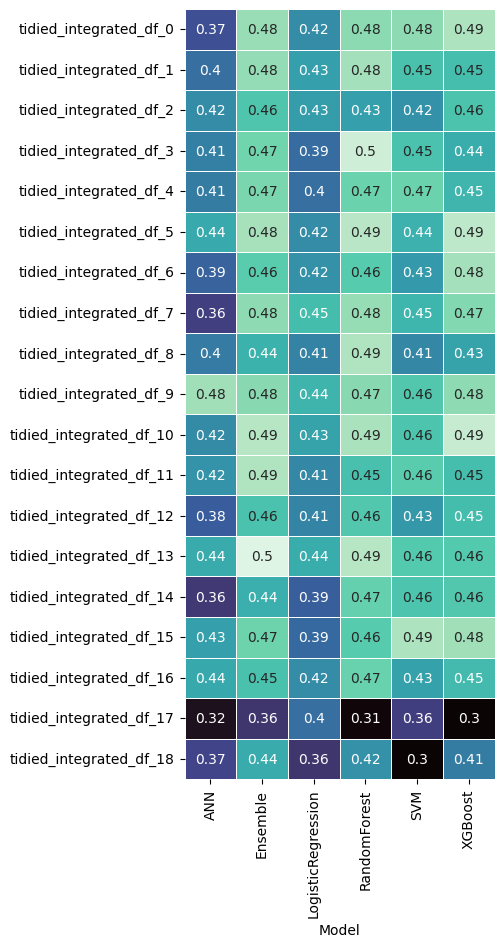

In [13]:
import seaborn as sns
pr_heatmap_df = metrics_df[["Dataset","Model","pr_auc_mean"]].pivot(index="Dataset", columns="Model",values="pr_auc_mean")
pr_heatmap_df.index = pd.Categorical(
    pr_heatmap_df.index,
    categories=sorted(pr_heatmap_df.index, key=lambda x: int(x.split('_')[-1])),
    ordered=True
)
pr_heatmap_df = pr_heatmap_df.sort_index()
fig, ax = plt.subplots(figsize=(4,10))    
ax = sns.heatmap(pr_heatmap_df,cmap='mako',annot=True,linewidth=0.5,cbar=False)

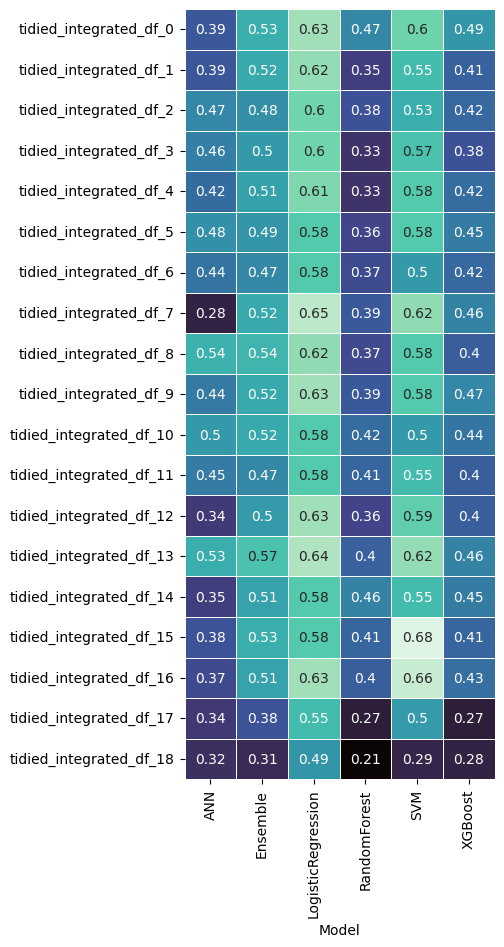

In [14]:
import seaborn as sns
rc_heatmap_df = metrics_df[["Dataset","Model","recall_mean"]].pivot(index="Dataset", columns="Model",values="recall_mean")
rc_heatmap_df.index = pd.Categorical(
    rc_heatmap_df.index,
    categories=sorted(rc_heatmap_df.index, key=lambda x: int(x.split('_')[-1])),
    ordered=True
)
rc_heatmap_df = rc_heatmap_df.sort_index()
fig, ax = plt.subplots(figsize=(4,10))    
ax = sns.heatmap(rc_heatmap_df,cmap='mako',annot=True,linewidth=0.5,cbar=False)

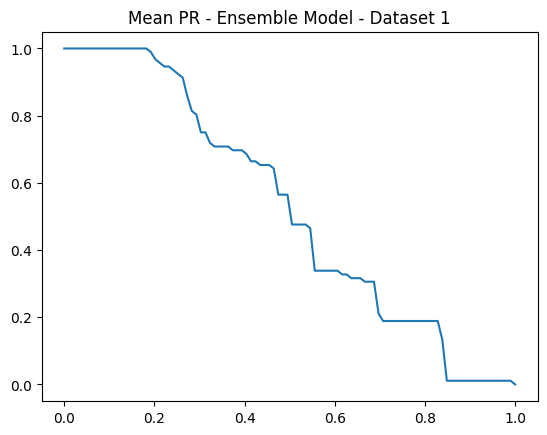

In [15]:
mean_fpr, mean_tpr = all_dataset_curves["pr"]["tidied_integrated_df_13"]["Ensemble"]
plt.plot(mean_fpr, mean_tpr)
plt.title("Mean PR - Ensemble Model - Dataset 1")
plt.show()

In [16]:
data["Srv"].mean()

0.1793372319688109

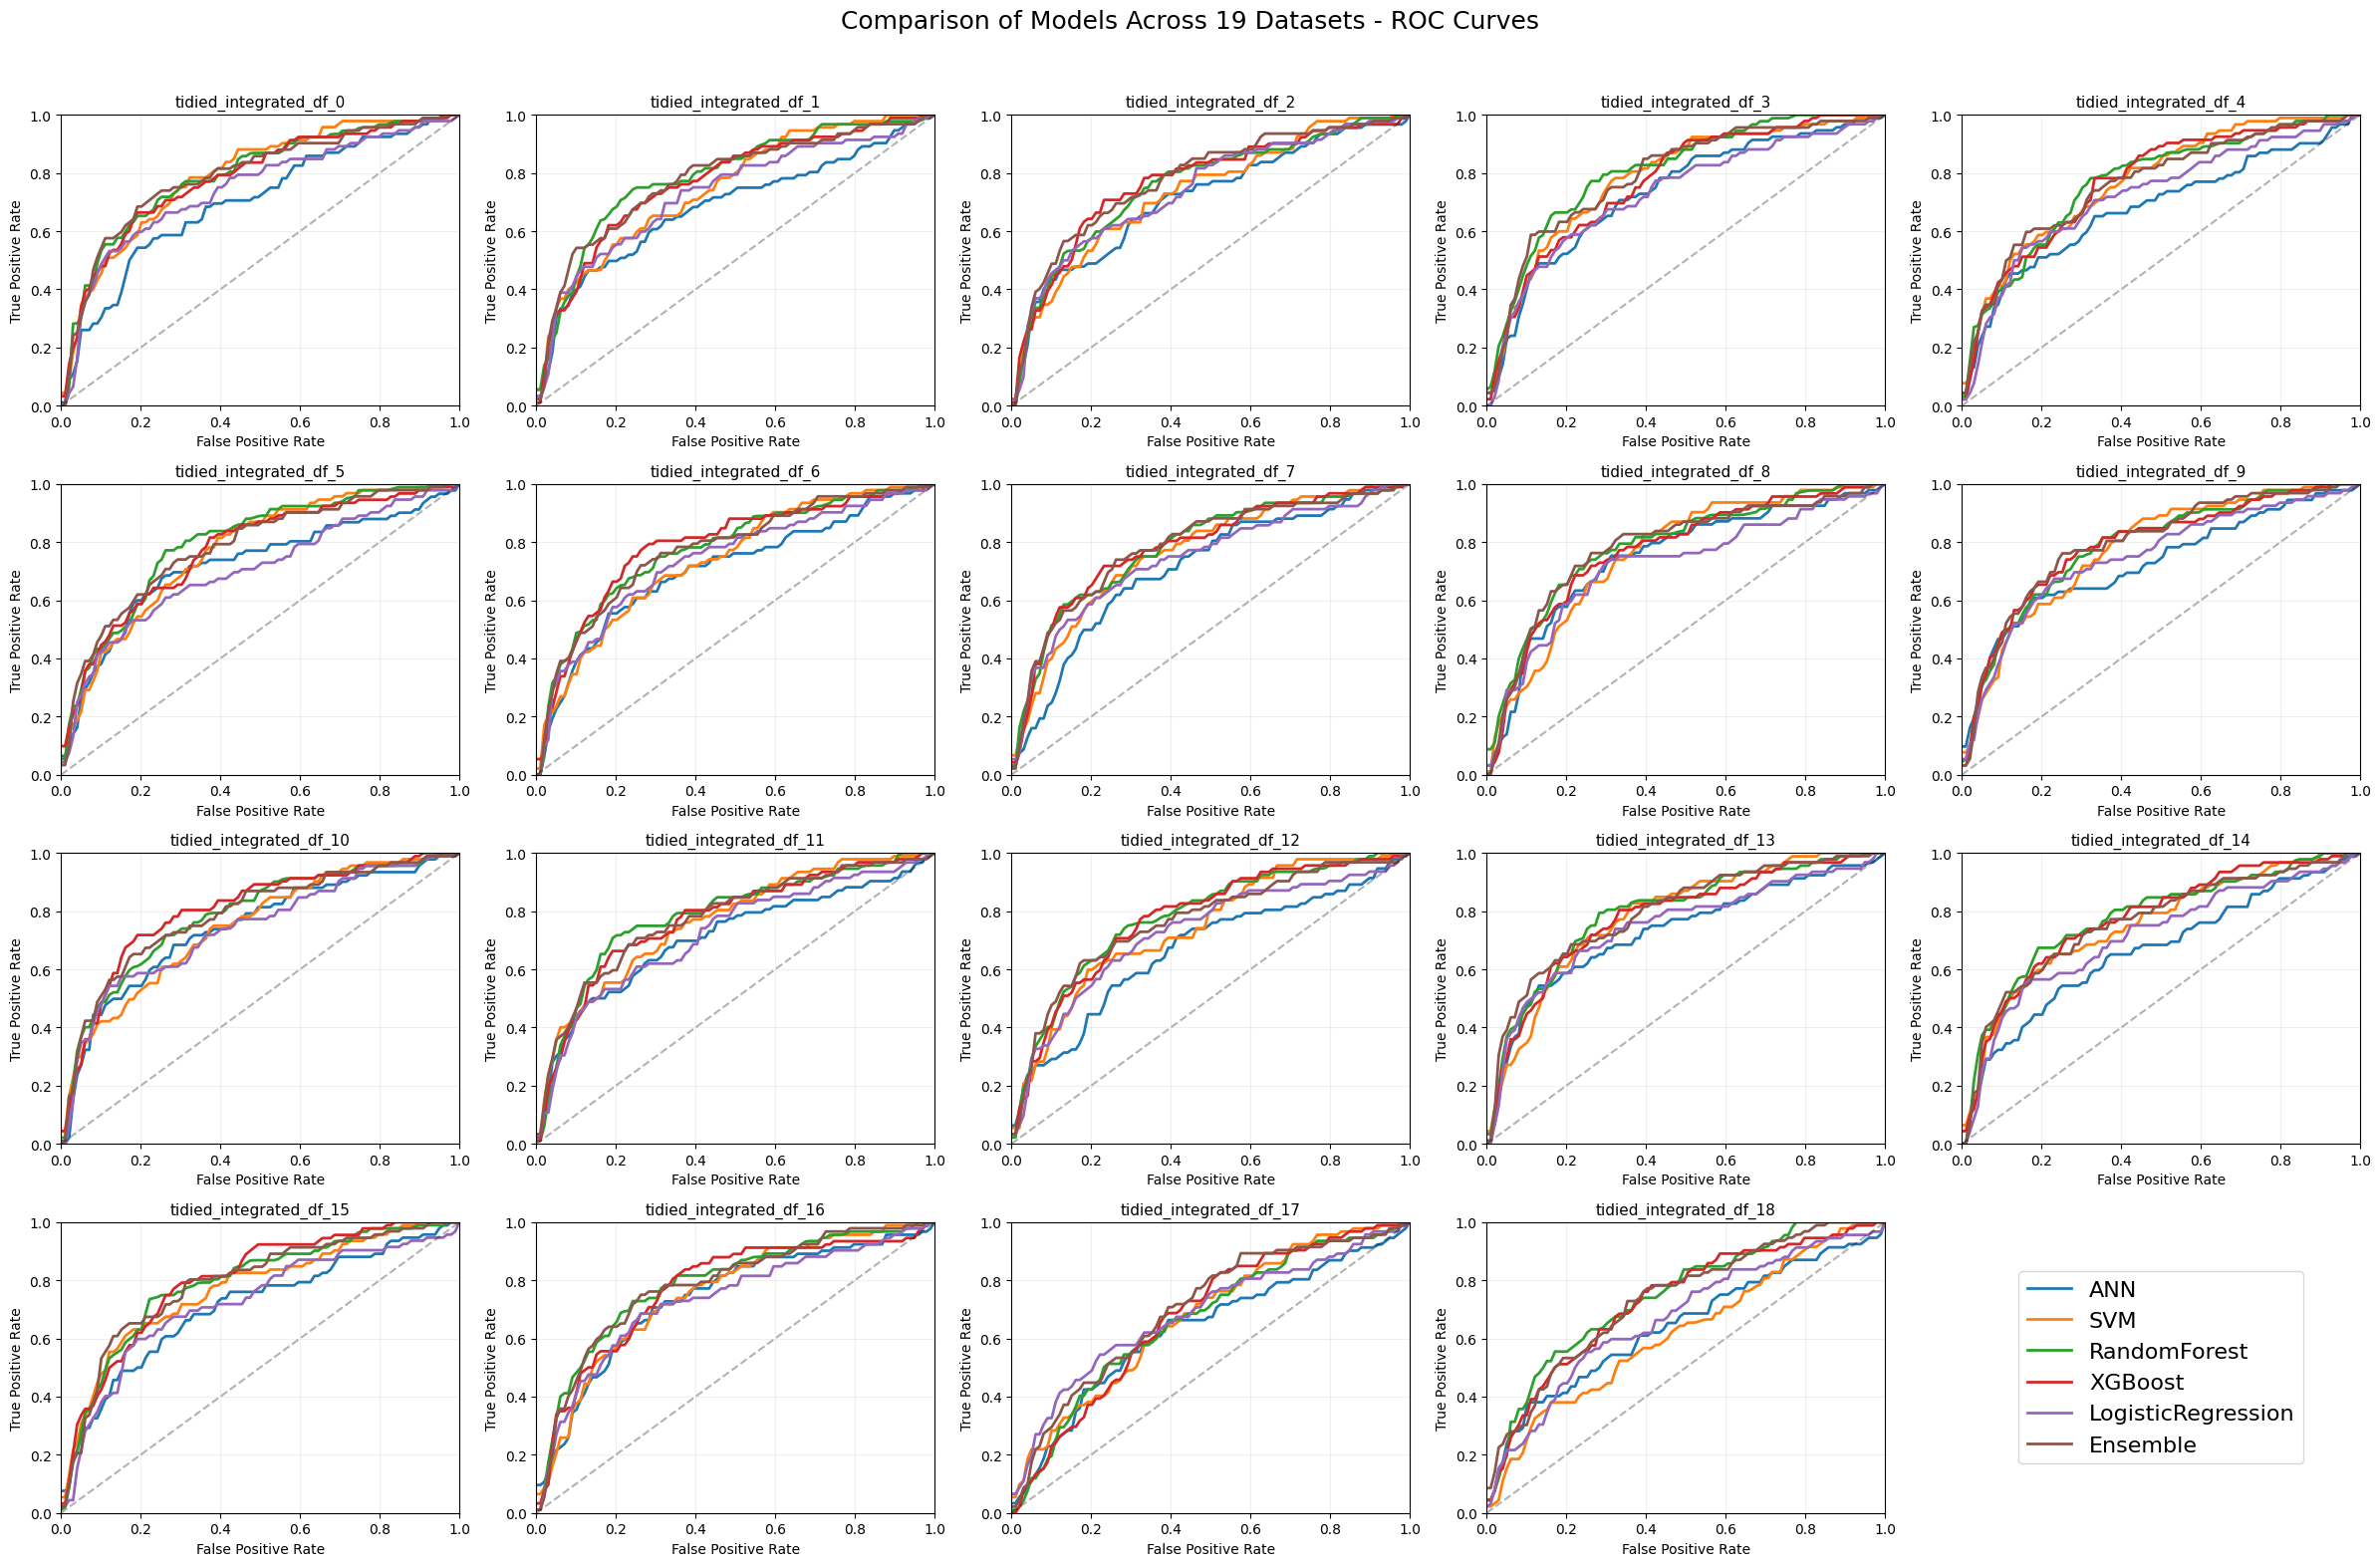

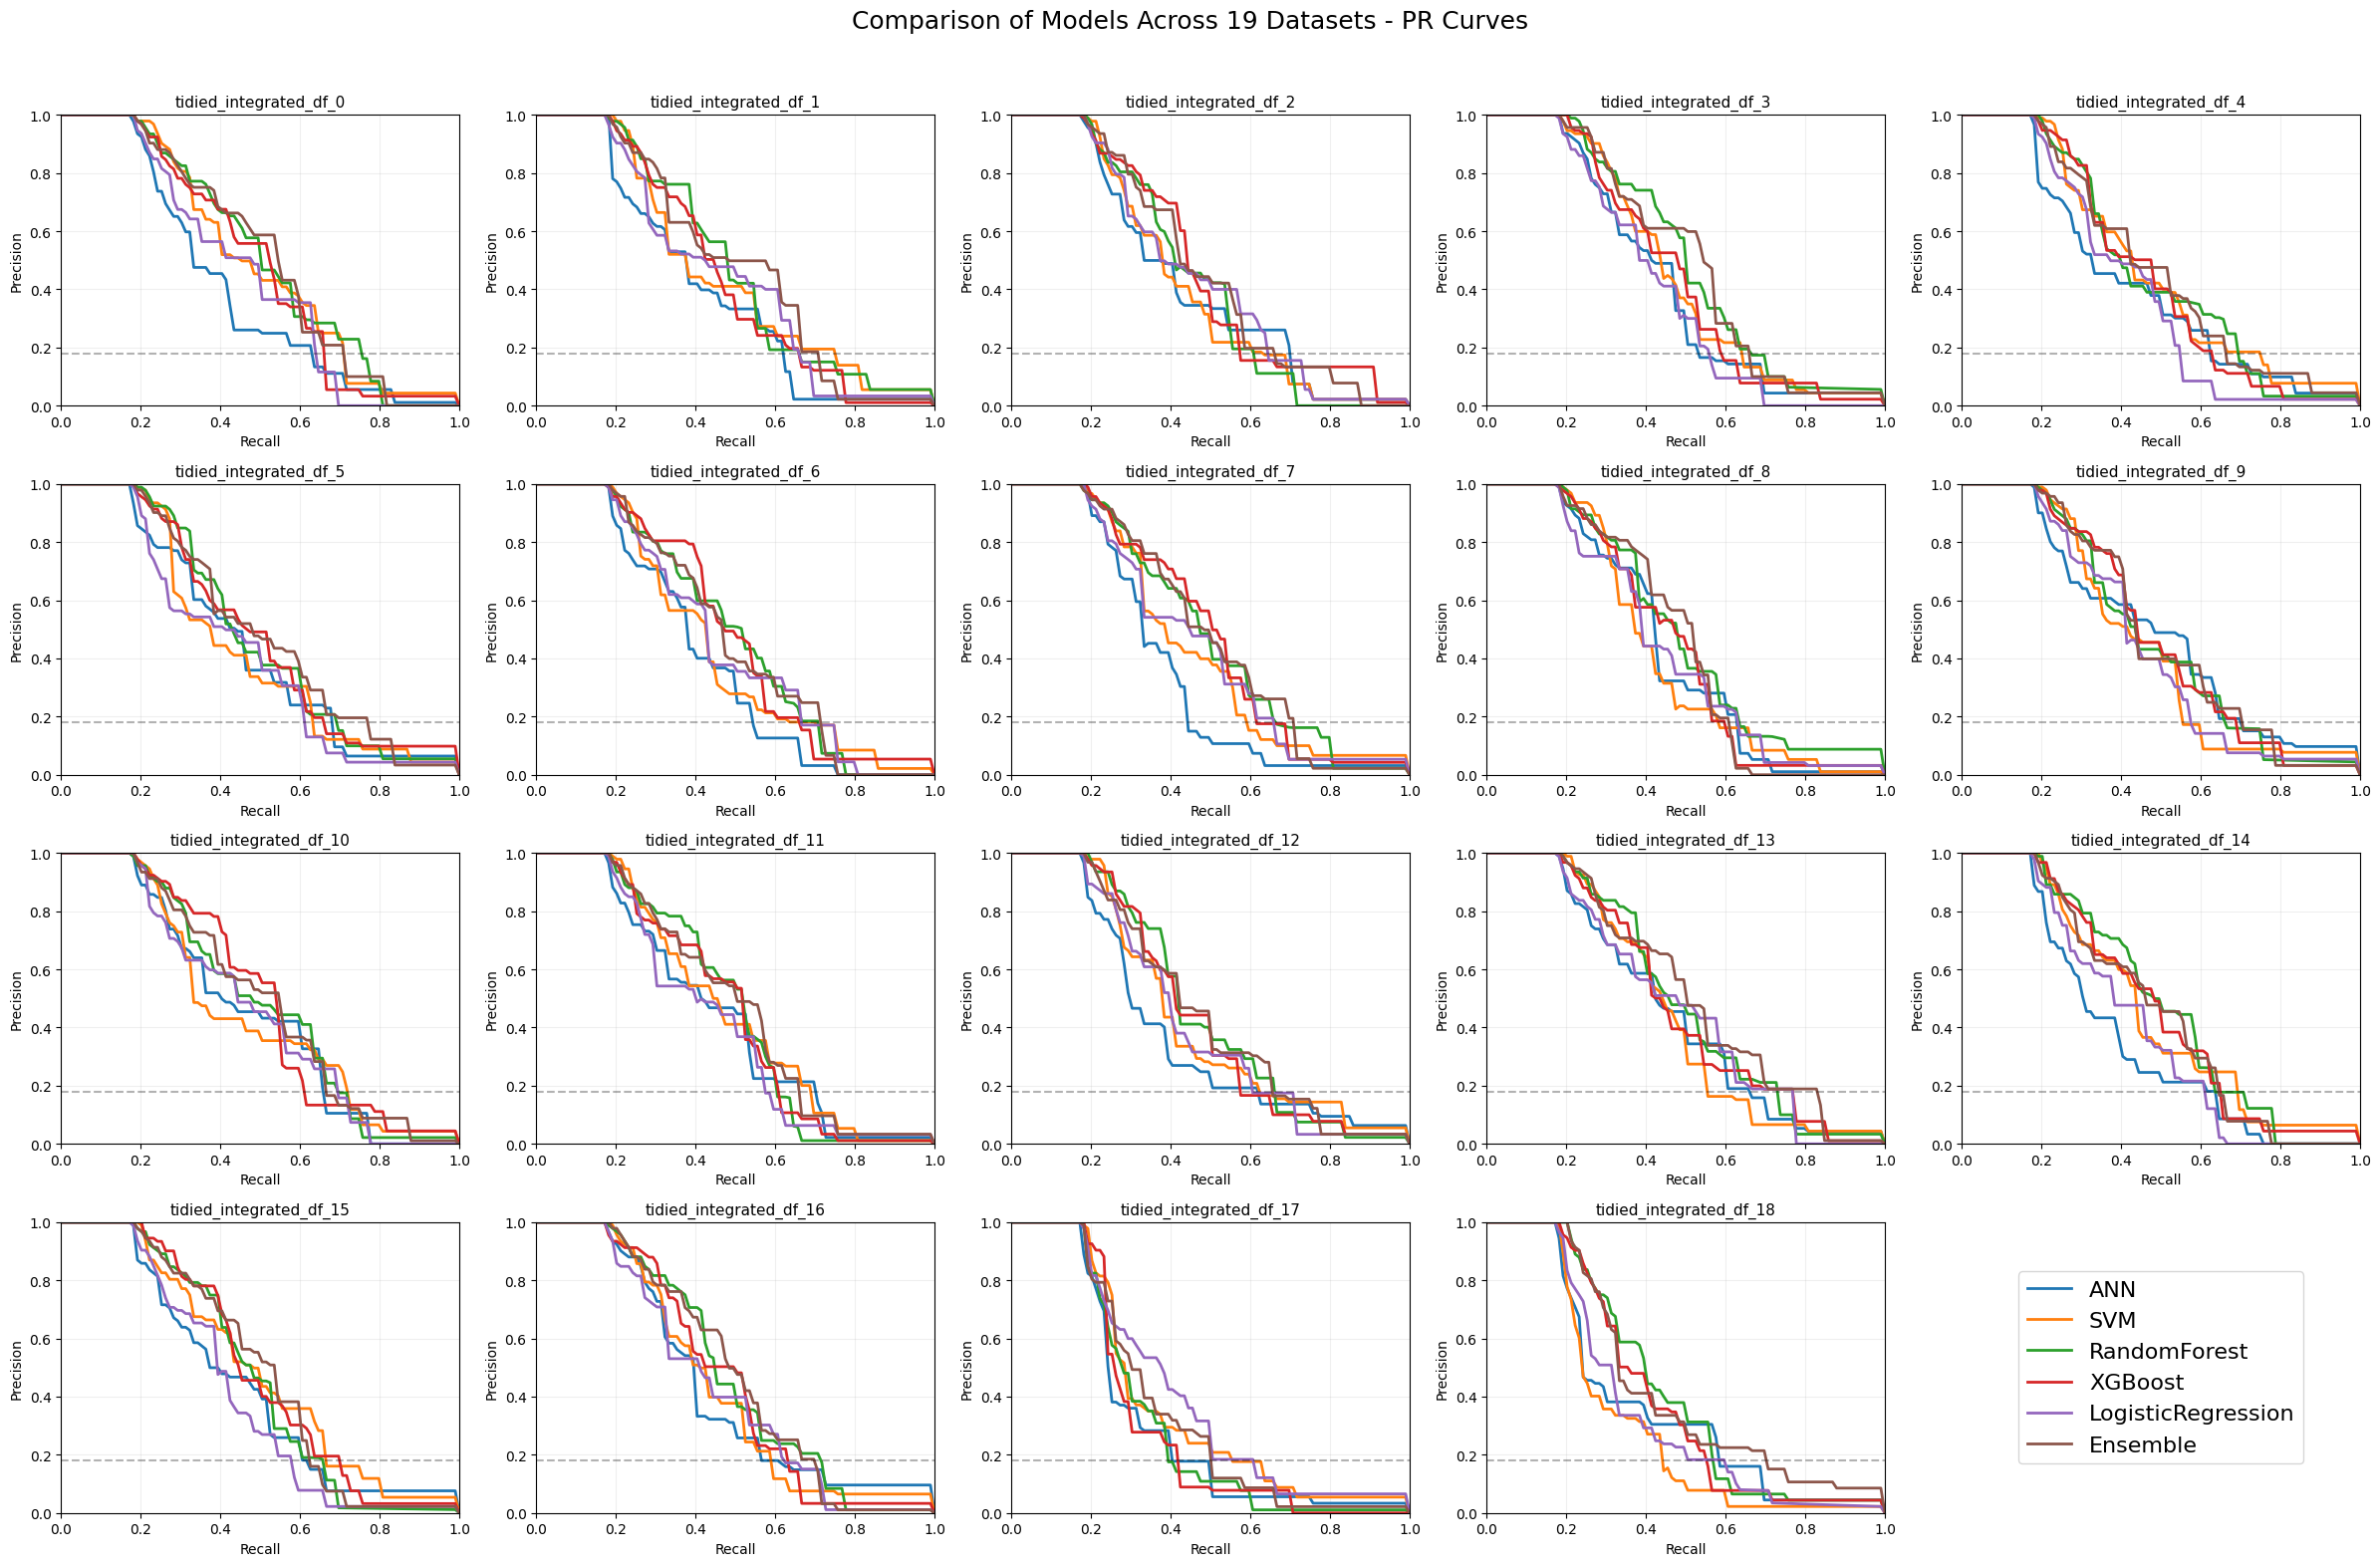

In [17]:
import matplotlib.pyplot as plt

def plot_all_datasets_comparison(curves_dict, curve_type="roc"):
    """
    Plots all datasets in a 4x5 grid, comparing all models for either ROC or PR curves.
    The final panel (20th) is reserved for the legend to avoid shrinking plots.
    
    Parameters
    ----------
    curves_dict : dict
        curves_dict["roc"] or curves_dict["pr"] with structure:
            { dataset_name: { model_name: (x, y) } }
    curve_type : str
        "roc" for ROC curves (FPR vs TPR)
        "pr" for Precision-Recall curves (Recall vs Precision)
    """
    
    assert curve_type in ["roc", "pr"], "curve_type must be 'roc' or 'pr'"

    # Setup 4x5 subplots (20 panels)
    fig, axes = plt.subplots(4, 5, figsize=(24, 16))
    axes = axes.flatten()

    # Get the list of models from the first dataset
    model_names = list(next(iter(curves_dict.values())).keys())

    for i, (ds_name, model_curves) in enumerate(curves_dict.items()):
        ax = axes[i]

        # Plot all models for this dataset
        for model_name, (x, y) in model_curves.items():
            ax.plot(x, y, label=model_name, lw=2)

        # Reference line
        if curve_type == "roc":
            ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
        else:
            ax.plot([0, 1], [data["Srv"].mean()] * 2, 'k--', alpha=0.3)
            ax.set_xlabel("Recall")
            ax.set_ylabel("Precision")

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title(ds_name, fontsize=11)
        ax.grid(True, alpha=0.2)

    # Use the 20th panel for legend only
    legend_ax = axes[len(curves_dict)]  # should be index 19
    legend_ax.axis("off")

    # Dummy lines for legend
    dummy_lines = [plt.Line2D([0], [0], color=plt.cm.tab10(i), lw=2) for i in range(len(model_names))]
    legend_ax.legend(dummy_lines, model_names, loc='center', fontsize=16, frameon=True)

    # Hide any remaining axes if curves_dict has < 19 datasets
    for j in range(len(curves_dict)+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"Comparison of Models Across {len(curves_dict)} Datasets - {curve_type.upper()} Curves", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Example usage:
# Plot ROC curves for all datasets
plot_all_datasets_comparison(all_dataset_curves["roc"], curve_type="roc")

# Plot PR curves for all datasets
plot_all_datasets_comparison(all_dataset_curves["pr"], curve_type="pr")
